In [49]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
iris = pd.read_csv('../Datasets/iris.csv', sep=';', names=["sepal length", "sepal width", "petal length", "petal width", "class"])
iris.name = "iris"
iris.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,0,1,2
0,1.70,0.15,1
1,3.65,2.05,1
2,2.10,2.40,1
3,2.35,2.20,1
4,4.10,2.30,1


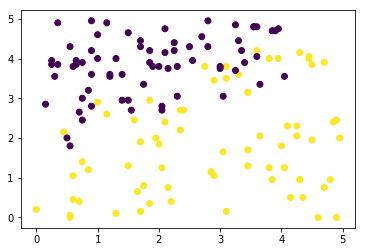

In [54]:
nonsep = pd.read_csv('../Datasets/nonsep.csv', sep=';', header=None)
nonsep.name = "non separable 2d"
display(nonsep.head())

plt.scatter(nonsep[0], nonsep[1], c=nonsep[2])
plt.show()

,0,1,2
0,1.70,0.15,1
1,3.65,2.05,1
2,2.10,2.40,1
3,2.35,2.20,1
4,4.10,2.30,1


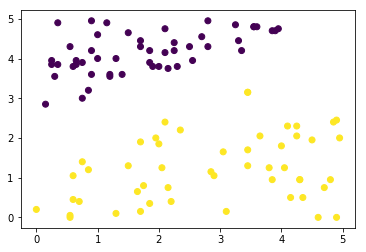

In [55]:
sep = pd.read_csv('../Datasets/sep.csv', sep=';', header=None)
sep.name = "separable 2d"
display(sep.head())

plt.scatter(sep[0], sep[1], c=sep[2])
plt.show()

In [24]:
tictactoe = pd.read_csv('../Datasets/tic-tac-toe.csv', sep=';', header=None)
tictactoe.name = "tic tac toe"
display(tictactoe.head())

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,1
1,x,x,x,x,o,o,o,x,o,1
2,x,x,x,x,o,o,o,o,x,1
3,x,x,x,x,o,o,o,b,b,1
4,x,x,x,x,o,o,b,o,b,1


In [25]:
def gini(classes):
    groups = {}
    for v in classes:
        if not v in groups:
            groups[v] = 0
        groups[v] = groups[v] + 1 
    #print("groups", groups)
    return 1 - sum(map(lambda p: (p / len(classes)) ** 2, groups.values()))

def weighted_gini(classes, split_index):
    g1 = gini(classes[:split_index])
    g2 = gini(classes[split_index:])
    #print("g1", g1, "g2", g2)
    g1w = g1 * (split_index / len(classes))
    g2w = g2 * ((len(classes) - split_index) / len(classes))
    #print("g1w", g1w, "g2w", g2w)
    return g1w + g2w

def find_best_gini(df):
    i = -1 # column
    g = 100 # worst gini
    s = -1 # split
    v = None # split value
    
    for column_index, column in enumerate(df.columns[:-1]):
        #print("COLUMN", column)
        df = df.sort_values(by=column)
        #display(df.head())
        for split in range(1, len(df)):
            #print(split)
            v1 = df.iloc[split - 1, column_index]
            #print("v1", v1)
            v2 = df.iloc[split, column_index]
            #print("v2", v2)
            if v1 == v2:
                # edge case when there are only records with same value 
                #print("Equal indexes {}".format(v1))
                continue
            newG = weighted_gini(df[df.columns[-1]], split)
            if newG < g:
                i, g, s, v = column, newG, split, (v1 + v2) / 2
                #print("column=", i, "g=", g, "s=", s, "v=", v, v1, v2)
        #print("column=", i, "g=", g, "s=", s, "v=", v)
    #print("column=", i, "g=", g, "s=", s, "v=", v)
    return i, g, v

In [26]:
class Node:
    def __init__(self, column, gini, value, samples):
        self.column = column
        self.gini = gini
        self.value = value
        self.samples = samples
        self.left = None
        self.right = None
    
    def __repr__(self):
        return "column={}, gini={}, value={}, samples={}".format(self.column, self.gini, self.value, self.samples)
    
    def is_leaf(self):
        return self.left is None and self.right is None

class DecisionTree:
    def __init__(self, root):
        self.root = root
    
    def predict(self, values):
        node = self.root
        while not node.is_leaf():
            if values[node.column] <= node.value:
                #print("go left")
                node = node.left
            else:
                #print("go right")
                node = node.right
        return node.value

def build_decision_tree(df):
    def build_node(df):
        column, gini, value = find_best_gini(df)
        #display(df.head())
        node = Node(column, gini, value, len(df))
        display(node)
        return node
    
    def build_node_recursively(parent, df, depth):
        print("depth", depth, parent, df.columns)
        if len(df) == 0:
            print("fail")
            return
        values = df[df.columns[-1]].unique()
        #print(values)
        if len(values) == 1:
            print("leaf", values[0])
            parent.value = values[0]
            return
        
        left_df = df[df[parent.column] <= parent.value]
        parent.left = build_node(left_df)
        print("build left")
        build_node_recursively(parent.left, left_df, depth + 1)
        
        right_df = df[df[parent.column] > parent.value]
        parent.right = build_node(right_df)
        print("build right")
        build_node_recursively(parent.right, right_df, depth + 1)
        
    root = build_node(df)
    build_node_recursively(root, df, 0)
    
    return DecisionTree(root)

In [29]:
def print_tree(current_node, indent='', last='updown'):
    def name(node):
        if current_node.is_leaf():
            return "class={}, s={}".format(node.value, node.samples)
        else:
            return "{}, v={}, s={}".format(node.column, node.value, node.samples)

    children = lambda node: [] if node.is_leaf() else [node.left, node.right]
    nb_children = lambda node: sum(nb_children(child) for child in children(node)) + 1
    size_branch = {child: nb_children(child) for child in children(current_node)}

    """ Creation of balanced lists for "up" branch and "down" branch. """
    up = sorted(children(current_node), key=lambda node: nb_children(node))
    down = []
    while up and sum(size_branch[node] for node in down) < sum(size_branch[node] for node in up):
        down.append(up.pop())

    """ Printing of "up" branch. """
    for child in up:
        next_last = 'up' if up.index(child) is 0 else ''
        next_indent = '{0}{1}{2}'.format(indent, ' ' if 'up' in last else '│', ' ' * len(name(current_node)))
        print_tree(child, next_indent, next_last)

    """ Printing of current node. """
    if last == 'up': start_shape = '┌'
    elif last == 'down': start_shape = '└'
    elif last == 'updown': start_shape = ' '
    else: start_shape = '├'

    if up: end_shape = '┤'
    elif down: end_shape = '┐'
    else: end_shape = ''

    print('{0}{1}{2}{3}'.format(indent, start_shape, name(current_node), end_shape))

    """ Printing of "down" branch. """
    for child in down:
        next_last = 'down' if down.index(child) is len(down) - 1 else ''
        next_indent = '{0}{1}{2}'.format(indent, ' ' if 'down' in last else '│', ' ' * len(name(current_node)))
        print_tree(child, next_indent, next_last)

In [28]:
def print_tree_simple(node, depth=0):
    if node == None:
        return
    
    type = "class" if node.is_leaf() else "value"
    print("{}column={}, {}={}".format(' ' * depth * 5, node.column, type, node.value))
    print_tree_simple(node.left, depth + 1)
    print_tree_simple(node.right, depth + 1)

In [45]:
def do_all(df):
    print(df.name)
    tree = build_decision_tree(df)
    
    correct = 0
    for i in range(len(df)):
        label = df.iloc[i, -1]
        predicted = tree.predict(df.iloc[i])
        if label == predicted:
            correct += 1
    print("Correct={}/{}".format(correct, len(df)))
    
    print_tree(tree.root)
    print_tree_simple(tree.root)

In [46]:
do_all(iris)

iris


column=petal length, gini=0.3333333333333333, value=2.45, samples=150

depth 0 column=petal length, gini=0.3333333333333333, value=2.45, samples=150 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=sepal length, gini=0.0, value=4.35, samples=50

build left
depth 1 column=sepal length, gini=0.0, value=4.35, samples=50 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 0


column=petal width, gini=0.11030595813204513, value=1.75, samples=100

build right
depth 1 column=petal width, gini=0.11030595813204513, value=1.75, samples=100 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=petal length, gini=0.0856481481481482, value=4.95, samples=54

build left
depth 2 column=petal length, gini=0.0856481481481482, value=4.95, samples=54 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=petal width, gini=0.0, value=1.65, samples=48

build left
depth 3 column=petal width, gini=0.0, value=1.65, samples=48 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=sepal length, gini=0.0, value=4.95, samples=47

build left
depth 4 column=sepal length, gini=0.0, value=4.95, samples=47 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 1


column=-1, gini=100, value=None, samples=1

build right
depth 4 column=-1, gini=100, value=None, samples=1 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 2


column=petal width, gini=0.2222222222222222, value=1.55, samples=6

build right
depth 3 column=petal width, gini=0.2222222222222222, value=1.55, samples=6 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=sepal length, gini=0.0, value=6.05, samples=3

build left
depth 4 column=sepal length, gini=0.0, value=6.05, samples=3 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 2


column=sepal length, gini=0.0, value=6.95, samples=3

build right
depth 4 column=sepal length, gini=0.0, value=6.95, samples=3 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=sepal length, gini=0.0, value=6.35, samples=2

build left
depth 5 column=sepal length, gini=0.0, value=6.35, samples=2 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 1


column=-1, gini=100, value=None, samples=1

build right
depth 5 column=-1, gini=100, value=None, samples=1 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 2


column=petal length, gini=0.02898550724637681, value=4.85, samples=46

build right
depth 2 column=petal length, gini=0.02898550724637681, value=4.85, samples=46 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=sepal length, gini=0.0, value=5.95, samples=3

build left
depth 3 column=sepal length, gini=0.0, value=5.95, samples=3 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')


column=-1, gini=100, value=None, samples=1

build left
depth 4 column=-1, gini=100, value=None, samples=1 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 1


column=sepal length, gini=0.0, value=6.1, samples=2

build right
depth 4 column=sepal length, gini=0.0, value=6.1, samples=2 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 2


column=sepal length, gini=0.0, value=5.65, samples=43

build right
depth 3 column=sepal length, gini=0.0, value=5.65, samples=43 Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')
leaf 2
Correct=150/150
                            ┌class=0, s=50
 petal length, v=2.45, s=150┤
                            │                                                     ┌class=2, s=43
                            │                          ┌petal length, v=4.85, s=46┤
                            │                          │                          │                         ┌class=1, s=1
                            │                          │                          └sepal length, v=5.95, s=3┤
                            │                          │                                                    └class=2, s=2
                            └petal width, v=1.75, s=100┤
                                                       │                                                    ┌class=1, s=47
                    

In [ ]:
do_all(tictactoe) # no number values

In [47]:
do_all(sep)

separable 2d


column=1, gini=0.038461538461538484, value=2.6500000000000004, samples=100

depth 0 column=1, gini=0.038461538461538484, value=2.6500000000000004, samples=100 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=0.275, samples=48

build left
depth 1 column=0, gini=0.0, value=0.275, samples=48 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=1, gini=0.038461538461538464, value=3.175, samples=52

build right
depth 1 column=1, gini=0.038461538461538464, value=3.175, samples=52 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=2.1, samples=4

build left
depth 2 column=0, gini=0.0, value=2.1, samples=4 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=0.45, samples=2

build left
depth 3 column=0, gini=0.0, value=0.45, samples=2 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=-1, gini=100, value=None, samples=2

build right
depth 3 column=-1, gini=100, value=None, samples=2 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=0.275, samples=48

build right
depth 2 column=0, gini=0.0, value=0.275, samples=48 Int64Index([0, 1, 2], dtype='int64')
leaf -1
Correct=100/100
                               ┌class=1, s=48
 1, v=2.6500000000000004, s=100┤
                               │                ┌class=-1, s=48
                               └1, v=3.175, s=52┤
                                                │             ┌class=-1, s=2
                                                └0, v=2.1, s=4┤
                                                              └class=1, s=2
column=1, value=2.6500000000000004
     column=0, class=1
     column=1, value=3.175
          column=0, value=2.1
               column=0, class=-1
               column=-1, class=1
          column=0, class=-1


In [48]:
do_all(nonsep)

non separable 2d


column=1, gini=0.25193798449612403, value=2.625, samples=140

depth 0 column=1, gini=0.25193798449612403, value=2.625, samples=140 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0808080808080808, value=0.8, samples=54

build left
depth 1 column=0, gini=0.0808080808080808, value=0.8, samples=54 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.13636363636363635, value=1.6, samples=11

build left
depth 2 column=1, gini=0.13636363636363635, value=1.6, samples=11 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=0.275, samples=7

build left
depth 3 column=0, gini=0.0, value=0.275, samples=7 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=0.475, samples=4

build right
depth 3 column=0, gini=0.0, value=0.475, samples=4 Int64Index([0, 1, 2], dtype='int64')


column=-1, gini=100, value=None, samples=1

build left
depth 4 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=0.525, samples=3

build right
depth 4 column=0, gini=0.0, value=0.525, samples=3 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=0, gini=0.0, value=1.0, samples=43

build right
depth 2 column=0, gini=0.0, value=1.0, samples=43 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.2675497024829037, value=2.325, samples=86

build right
depth 1 column=0, gini=0.2675497024829037, value=2.325, samples=86 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.0680851063829787, value=2.975, samples=47

build left
depth 2 column=1, gini=0.0680851063829787, value=2.975, samples=47 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.2, value=2.875, samples=10

build left
depth 3 column=1, gini=0.2, value=2.875, samples=10 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=0.425, samples=6

build left
depth 4 column=0, gini=0.0, value=0.425, samples=6 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=0, gini=0.3333333333333333, value=1.2, samples=4

build right
depth 4 column=0, gini=0.3333333333333333, value=1.2, samples=4 Int64Index([0, 1, 2], dtype='int64')


column=-1, gini=100, value=None, samples=1

build left
depth 5 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=1.675, samples=3

build right
depth 5 column=0, gini=0.0, value=1.675, samples=3 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=1.45, samples=2

build left
depth 6 column=0, gini=0.0, value=1.45, samples=2 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=-1, gini=100, value=None, samples=1

build right
depth 6 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=0.275, samples=37

build right
depth 3 column=0, gini=0.0, value=0.275, samples=37 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=1, gini=0.3228869895536562, value=4.25, samples=39

build right
depth 2 column=1, gini=0.3228869895536562, value=4.25, samples=39 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.40404040404040414, value=4.175, samples=27

build left
depth 3 column=0, gini=0.40404040404040414, value=4.175, samples=27 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.4480519480519481, value=3.525, samples=22

build left
depth 4 column=1, gini=0.4480519480519481, value=3.525, samples=22 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.21428571428571433, value=3.55, samples=8

build left
depth 5 column=0, gini=0.21428571428571433, value=3.55, samples=8 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.19047619047619047, value=3.0999999999999996, samples=7

build left
depth 6 column=1, gini=0.19047619047619047, value=3.0999999999999996, samples=7 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=2.7249999999999996, samples=3

build left
depth 7 column=0, gini=0.0, value=2.7249999999999996, samples=3 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=2.375, samples=2

build left
depth 8 column=0, gini=0.0, value=2.375, samples=2 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=-1, gini=100, value=None, samples=1

build right
depth 8 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=0, gini=0.0, value=3.0, samples=4

build right
depth 7 column=0, gini=0.0, value=3.0, samples=4 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=-1, gini=100, value=None, samples=1

build right
depth 6 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=0, gini=0.45714285714285713, value=3.5, samples=14

build right
depth 5 column=0, gini=0.45714285714285713, value=3.5, samples=14 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.3333333333333333, value=3.6500000000000004, samples=9

build left
depth 6 column=1, gini=0.3333333333333333, value=3.6500000000000004, samples=9 Int64Index([0, 1, 2], dtype='int64')


column=-1, gini=100, value=None, samples=1

build left
depth 7 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.3, value=3.175, samples=8

build right
depth 7 column=0, gini=0.3, value=3.175, samples=8 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.30000000000000004, value=3.05, samples=5

build left
depth 8 column=0, gini=0.30000000000000004, value=3.05, samples=5 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.25, value=2.875, samples=4

build left
depth 9 column=0, gini=0.25, value=2.875, samples=4 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.0, value=2.65, samples=2

build left
depth 10 column=0, gini=0.0, value=2.65, samples=2 Int64Index([0, 1, 2], dtype='int64')


column=-1, gini=100, value=None, samples=1

build left
depth 11 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=-1, gini=100, value=None, samples=1

build right
depth 11 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=1, gini=0.0, value=3.775, samples=2

build right
depth 10 column=1, gini=0.0, value=3.775, samples=2 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=-1, gini=100, value=None, samples=1

build right
depth 9 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=3.3, samples=3

build right
depth 8 column=0, gini=0.0, value=3.3, samples=3 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=0, gini=0.30000000000000004, value=4.0, samples=5

build right
depth 6 column=0, gini=0.30000000000000004, value=4.0, samples=5 Int64Index([0, 1, 2], dtype='int64')


column=0, gini=0.25, value=3.7, samples=4

build left
depth 7 column=0, gini=0.25, value=3.7, samples=4 Int64Index([0, 1, 2], dtype='int64')


column=1, gini=0.0, value=4.125, samples=2

build left
depth 8 column=1, gini=0.0, value=4.125, samples=2 Int64Index([0, 1, 2], dtype='int64')


column=-1, gini=100, value=None, samples=1

build left
depth 9 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=-1, gini=100, value=None, samples=1

build right
depth 9 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=3.875, samples=2

build right
depth 8 column=0, gini=0.0, value=3.875, samples=2 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=-1, gini=100, value=None, samples=1

build right
depth 7 column=-1, gini=100, value=None, samples=1 Int64Index([0, 1, 2], dtype='int64')
leaf -1


column=0, gini=0.0, value=4.375, samples=5

build right
depth 4 column=0, gini=0.0, value=4.375, samples=5 Int64Index([0, 1, 2], dtype='int64')
leaf 1


column=0, gini=0.0, value=2.6, samples=12

build right
depth 3 column=0, gini=0.0, value=2.6, samples=12 Int64Index([0, 1, 2], dtype='int64')
leaf -1
Correct=140/140
                                 ┌class=1, s=43
                  ┌0, v=0.8, s=54┤
                  │              │              ┌class=1, s=7
                  │              └1, v=1.6, s=11┤
                  │                             │               ┌class=1, s=1
                  │                             └0, v=0.475, s=4┤
                  │                                             └class=-1, s=3
 1, v=2.625, s=140┤
                  │                                 ┌class=-1, s=37
                  │                ┌1, v=2.975, s=47┤
                  │                │                │                ┌class=-1, s=6
                  │                │                └1, v=2.875, s=10┤
                  │                │                                 │             ┌class=1, s=1
                  │                │                             